<a href="https://colab.research.google.com/github/adarsh1github1/Super-resolution-of-blurred-images/blob/main/Super_resolution_using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [18]:
# cloud system configurations
!nvidia-smi

Fri May 14 16:06:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    32W /  70W |    238MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
##computer vision
import cv2  #open cv
import numpy as np #numpy

#tensorflow methods and classes for model creation 
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

#file processing
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Dataset   --- Labeled faces in wild  
# dataset  --- COMPUTER VISION LAB at University of Massechusets Amherst
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2021-05-14 15:39:15--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  63.0MB/s    in 2.7s    

2021-05-14 15:39:18 (63.0 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [5]:
# extract dataset
! tar -xvzf lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

In [6]:
#capture paths to images in all folders
train_images = glob.glob('lfw/**/*.jpg')

In [7]:
#resizing images for training
all_images = []

for i in tqdm(train_images):
  img = image.load_img(i, target_size=(120,120,3))
  img = image.img_to_array(img)
  img = img/255.       #normalization
  all_images.append(img)

100%|██████████| 13233/13233 [00:27<00:00, 477.61it/s]


In [10]:
#making data ready for trainig

# converting to array
all_images = np.array(all_images)

# split data into train and validation data
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)

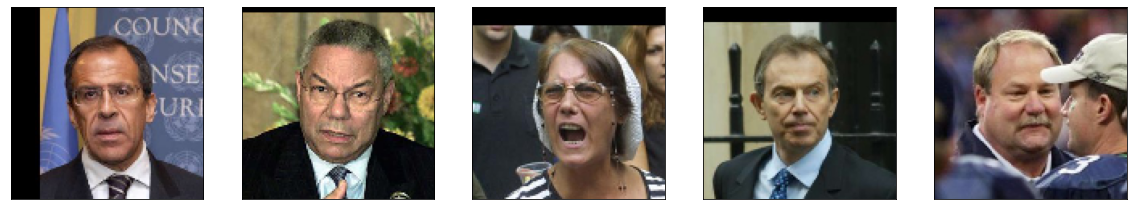

In [11]:
#plotting example from the dataset
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(train_x[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [12]:
# reduce image resolution
# resolution is reduced but image size is kept constant

def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [13]:
# preparing low resolution dataset for training set. 
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)

# preparing low resolution dataset for validation set. 
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

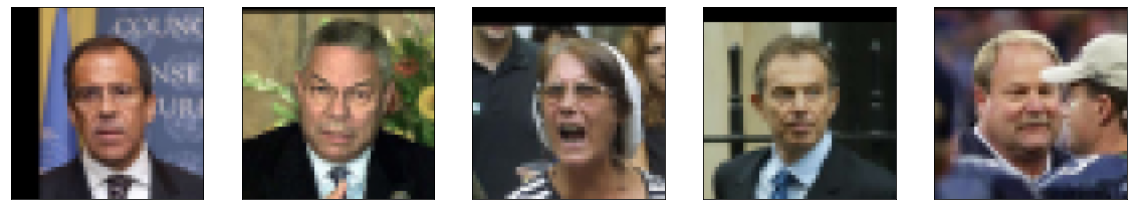

In [14]:
#plotting example from the resized dataset
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(train_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [17]:
#creating the model

Input_img = Input(shape=(120, 120, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoder = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)


# decoding architecture
x7 = UpSampling2D()(encoder)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

decoder = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

#compiling model with Adam optimizer , MSE loss function and accuracy as metrics
autoencoder = Model(Input_img, decoder)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  

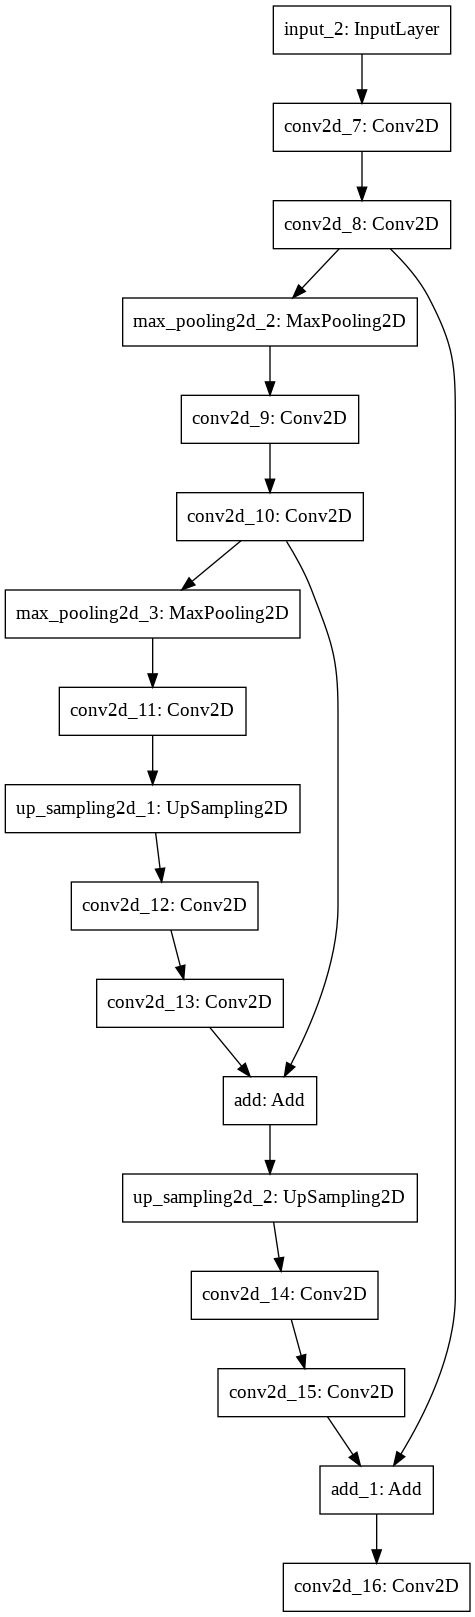

In [19]:
#model architecture visualization
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='encoder_model.png')

In [20]:
#summary of model - trainable and non trainable parameters
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 120, 120, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 120, 120, 64) 36928       conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 60, 60, 64)   0           conv2d_8[0][0]                   
______________________________________________________________________________________________

In [21]:
#early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=4, verbose=1, mode='auto')
a_e = autoencoder.fit(train_x_px, train_x,
            epochs=50,
            batch_size=128,
            shuffle=True,
            validation_data=(val_x_px, val_x))

Epoch 1/50
94/94 [==============================] - 128s 868ms/step - loss: 0.0543 - accuracy: 0.5387 - val_loss: 0.0021 - val_accuracy: 0.8958
Epoch 2/50
94/94 [==============================] - 77s 819ms/step - loss: 0.0020 - accuracy: 0.8895 - val_loss: 0.0016 - val_accuracy: 0.9063
Epoch 3/50
94/94 [==============================] - 78s 825ms/step - loss: 0.0016 - accuracy: 0.8986 - val_loss: 0.0016 - val_accuracy: 0.8906
Epoch 4/50
94/94 [==============================] - 78s 827ms/step - loss: 0.0015 - accuracy: 0.9081 - val_loss: 0.0014 - val_accuracy: 0.9106
Epoch 5/50
94/94 [==============================] - 78s 827ms/step - loss: 0.0014 - accuracy: 0.9188 - val_loss: 0.0014 - val_accuracy: 0.8869
Epoch 6/50
94/94 [==============================] - 78s 827ms/step - loss: 0.0013 - accuracy: 0.9121 - val_loss: 0.0013 - val_accuracy: 0.9034
Epoch 7/50
94/94 [==============================] - 78s 825ms/step - loss: 0.0013 - accuracy: 0.9181 - val_loss: 0.0013 - val_accuracy: 0.921

In [22]:
predictions = autoencoder.predict(val_x_px)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


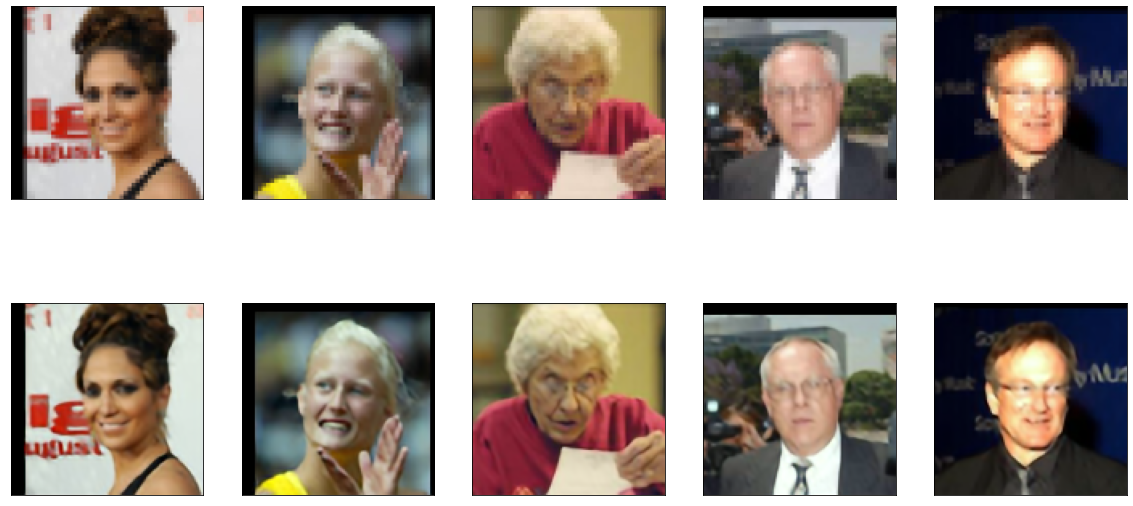

In [23]:
#plotting the results
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


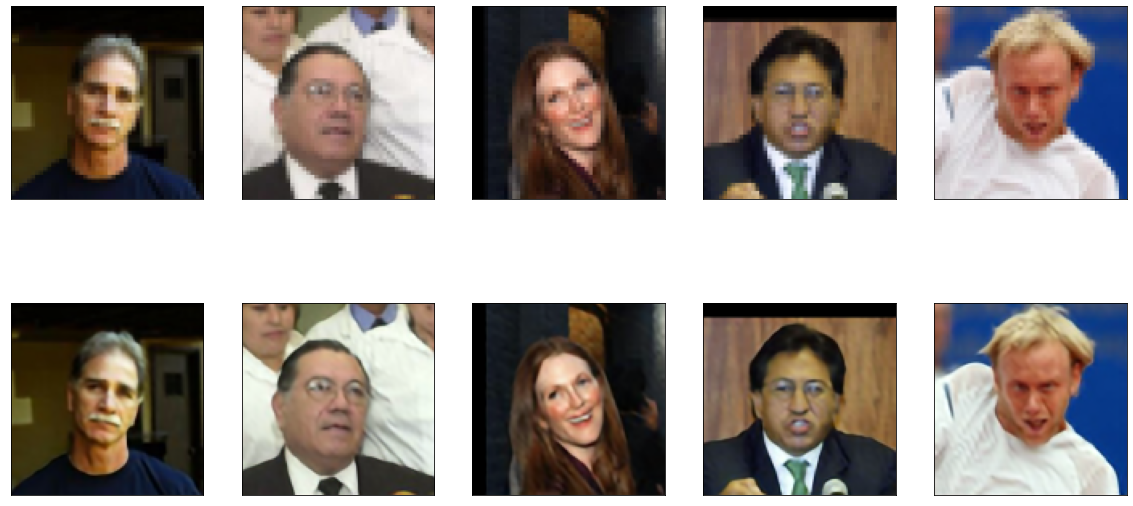

In [24]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i+25])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+25])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

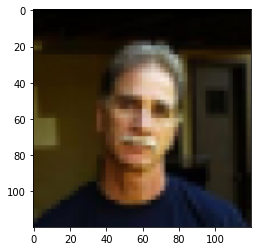

In [25]:
plt.imshow(val_x_px[25])
plt.show()

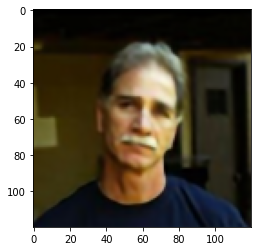

In [26]:
plt.imshow(predictions[25])
plt.show()

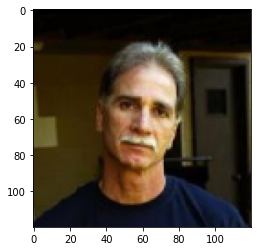

In [28]:
plt.imshow(val_x[25])
plt.show()

In [29]:
#calculating the PSNR value for resultant image. 

from math import log10, sqrt
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def main():
     original = cv2.imread("original.png")
     compressed = cv2.imread("resolved.png", 1)
     value = PSNR(original, compressed)
     print(f"PSNR value is {value} dB")
       
if __name__ == "__main__":
    main()

PSNR value is 37.843142115019724 dB


In [30]:
def main():
     original = cv2.imread("resolved.png")
     compressed = cv2.imread("lr.png", 1)
     value = PSNR(original, compressed)
     print(f"PSNR value is {value} dB")

In [31]:
if __name__ == "__main__":
    main()

PSNR value is 36.41974384088229 dB
